**Imports**

In [1]:
using FFTW, Plots
using DSP: unwrap, conv

include("models.jl")
include("nonlinearity.jl")

setup_nonlinearity_term (generic function with 3 methods)

**Constants / Material & Signal parameters**

In [2]:
# CONSTANTS
c = 299792458

# WAVEGUIDE
fr = 0.18
τl = 32e-15
τvib = 12.2e-15
L = 0.5
α = 0.0
γ = 0.11
λc = 835e-9
ω0 = 2π*c/λc
βs = [0.0, -1.1830e-026]

# SIGNAL 
T = 12.5e-12 # Duration
N = 2^14 # Time samples
τ = 0.05e-12/ (2log(1+sqrt(2)))
P = abs(βs[2]/(γ*τ^2))
n = 3
# VECTORS 
dt = T/N
t = T*(-N÷2:N÷2-1)/N;
ν = fftshift((-N÷2:N÷2-1)./T);
ω = 2π.*ν;

u0 = n*sqrt(P)*sech.(t ./ τ);

**Simulation parameters**

In [7]:
# SIMULATION 

nsaves = 250


u = ComplexF64.(u0)
FFT = plan_fft(u)
IFFT = plan_ifft(u)


hr = (τvib^2 + τl^2) / τvib / τl^2 * exp.(-t / τl) .* sin.(t / τvib)
hr[t.<=0] .= 0.0
RW = conj((FFT * ifftshift(hr)))
D = -0.5α .+ 1im * sum([(βs[i] / factorial(i)) .* ω .^ i for i in eachindex(βs)]);
NL = setup_nonlinearity_term()
model = Model(FFT, IFFT, dt, fr, γ, RW, ω, ω0, D, NL)

function _compute_error(a, b)
    sqrt(sum(abs2.(a .- b)) ./ sum(abs2.(a)))
end

function _integrate_to_z(stepper, z, model, maxiters, reltol)
    it = 0
    while stepper.z < z

        e = exp.(0.5 * stepper.dz * model.D)

        Uip = e .* stepper.U

        k1 = e .* stepper.NU

        k2 = model.NL(model.IFFT * (Uip .+ 0.5 * stepper.dz * k1), model)

        k3 = model.NL(model.IFFT * (Uip .+ 0.5 * stepper.dz * k2), model)

        k4 = model.NL(model.IFFT * (e .* (Uip .+ stepper.dz * k3)), model)

        r = e .* (Uip .+ stepper.dz * (k1 / 6.0 .+ k2 / 3.0 .+ k3 / 3.0))

        U1 = r .+ stepper.dz * k4 / 6.0

        stepper.k5 = model.NL(model.IFFT * U1, model)

        U2 = r .+ stepper.dz * (k4 / 15.0 .+ stepper.k5 / 10.0)

        stepper.local_error = _compute_error(U1, U2)

        dzopt =
            max(0.5, min(2.0, 0.9 * sqrt(sqrt(reltol / stepper.local_error)))) * stepper.dz

        if stepper.local_error <= reltol

            stepper.dz = min(dzopt, abs(z - stepper.z))
            stepper.z = stepper.z + stepper.dz
            stepper.U = U1
            stepper.NU = stepper.k5
        else
            stepper.dz = dzopt
            it = it + 1
            if (it >= maxiters)
                throw(ErrorException("Max number of iteration exceeded!"))
            end
        end
    end
end

mutable struct Solution 
    z 
    t 
    f
    At 
    Af
end

function propagate(u,t,L, nsaves, model, dz=1.0, reltol=1e-6, maxiters=1000)

    T = t[end]-t[1]
    ν = fftshift((-N÷2:N÷2-1)./T);


    # initial stepper
    stepper = Stepper(model.FFT * u, model.NL(u, model), dz, 0.0, 0.0, 0.0)
    zsaves = (0:nsaves) * L / nsaves
    dz = min(L / (2 * nsaves), dz)
    M = zeros(ComplexF64, (nsaves + 1, N)); M[1, :] = stepper.U;
    ϵ_hist = zeros(nsaves + 1); ϵ_hist[1]=0.0;


    for i = 2:nsaves+1
        _integrate_to_z(stepper, zsaves[i], model, maxiters, reltol)
        ϵ_hist[i] = stepper.local_error
        M[i, :] = stepper.U
    end

    return Solution(zsaves, t, ν, ifft(M, 2), M)
end

SOL = propagate(u,t, L, nsaves, model);


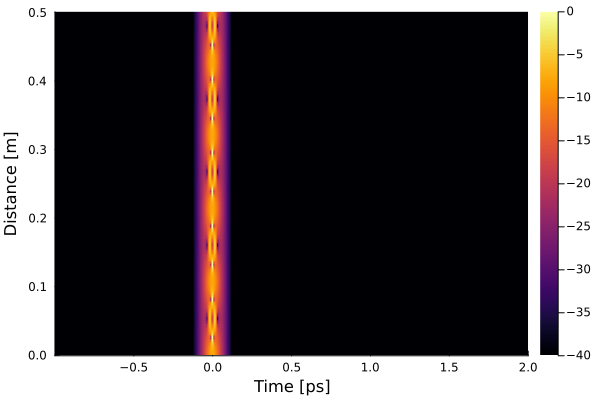

In [6]:
TT =  -1e-12 .<= t .<= 2e-12
SOLr = reverse(SOL.At, dims=2)[:,TT] .|> abs2 
SOLr = SOLr ./ maximum(SOLr)
MIT = 10log10.(SOLr)

heatmap(t[TT]*1e12, SOL.z, MIT, clims=(-40,0))
xlabel!("Time [ps]")
ylabel!("Distance [m]")



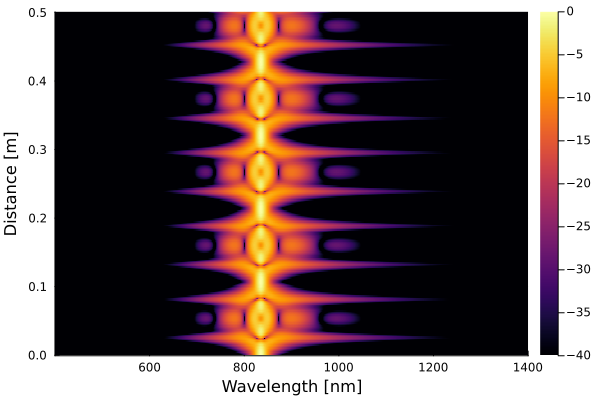

In [14]:
V =  (fftshift(reverse(ω)) .+ ω0)
WL = (2pi*c ./ V * 1e9)
widx = 400 .<= WL .<= 1400
WSOLr = reverse(ifftshift(fft(SOL,2),2), dims=2)[:,widx] .|> abs2 
WSOLr = WSOLr ./ maximum(WSOLr)
MIW = 10log10.(WSOLr)

heatmap(WL[widx], zsaves, MIW, clims=(-40,0))
xlabel!("Wavelength [nm]")
ylabel!("Distance [m]")


**Able to reproduce perfectly the results from other packages**

Here we reproduced the 3rd order soliton simulations from the python module *gnlse*.

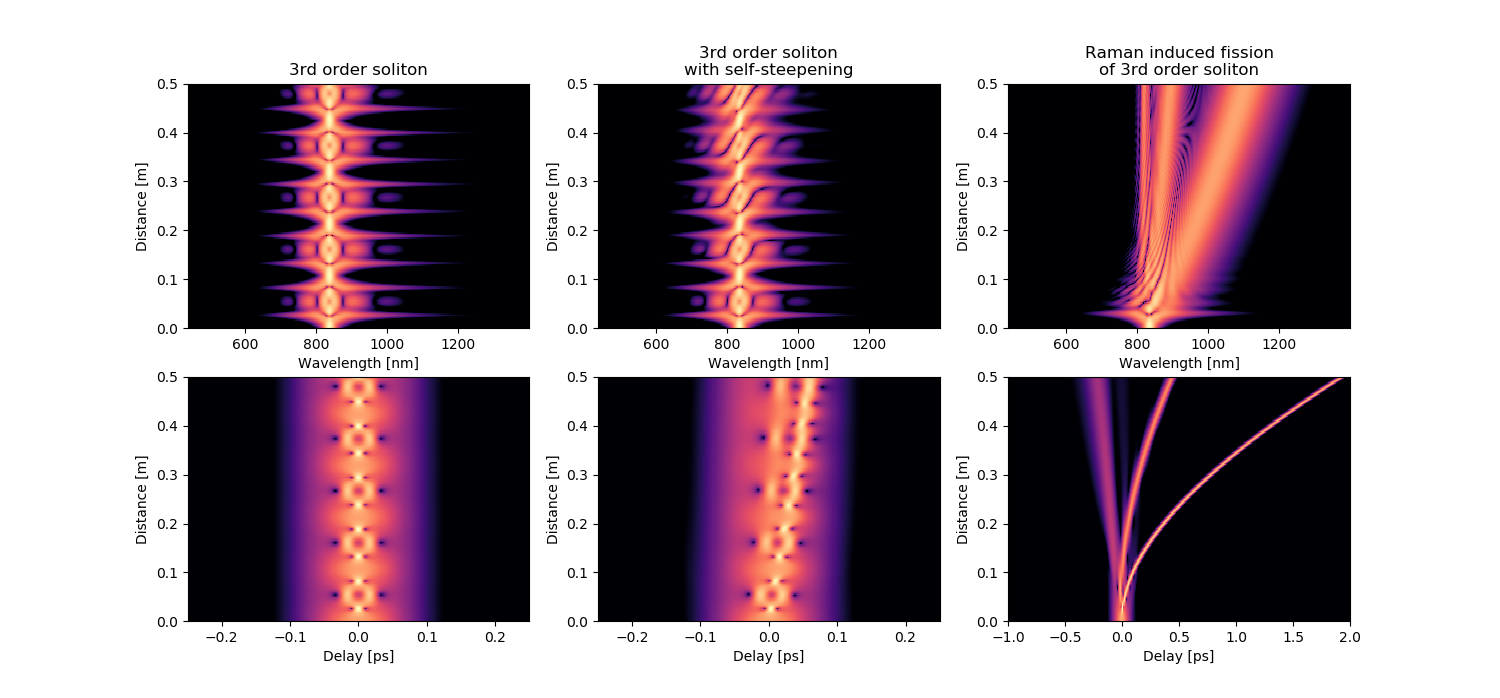

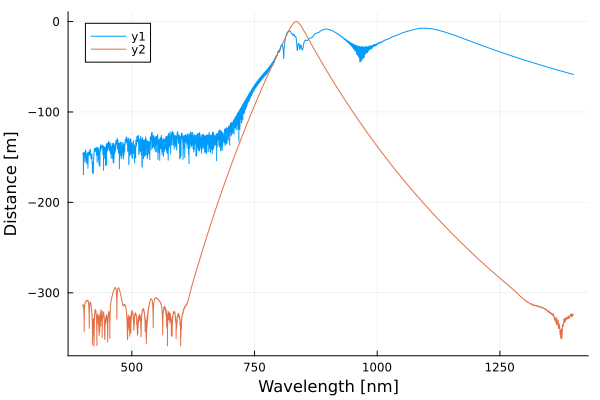

In [276]:
V =  (fftshift(reverse(ω)) .+ ω0)
WL = (2pi*c ./ V * 1e9)
widx = 400 .<= WL .<= 1400
WSOLr = reverse(ifftshift(M,2), dims=2)[:,widx] .|> abs2 
WSOLr = WSOLr ./ maximum(WSOLr)
MIW = 10log10.(WSOLr)

plot(WL[widx], MIW[end,:], clims=(-40,0))
plot!(WL[widx], MIW[1,:], clims=(-40,0))
xlabel!("Wavelength [nm]")
ylabel!("Distance [m]")

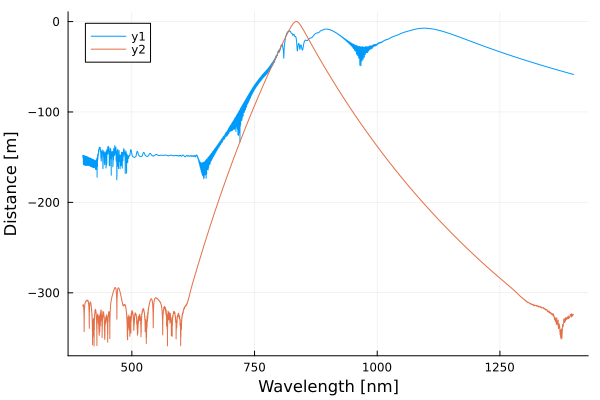

In [272]:
V =  (fftshift(reverse(ω)) .+ ω0)
WL = (2pi*c ./ V * 1e9)
widx = 400 .<= WL .<= 1400
WSOLr = reverse(ifftshift(M,2), dims=2)[:,widx] .|> abs2 
WSOLr = WSOLr ./ maximum(WSOLr)
MIW = 10log10.(WSOLr)

plot(WL[widx], MIW[end,:], clims=(-40,0))
plot!(WL[widx], MIW[1,:], clims=(-40,0))
xlabel!("Wavelength [nm]")
ylabel!("Distance [m]")